In [1]:
# Function to decode operation

In [2]:
%pylab inline 

import mne
from mne.datasets import spm_face
from mne.decoding import GeneralizationAcrossTime
import sys
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
from scipy import stats
#Add personal functions to python path
sys.path.append('/neurospin/meg/meg_tmp/Calculation_Pedro_2014/scripts/decoding/')
#sys.path.append('/Volumes/NeuroSpin2T/Calculation_Pedro_2014/scripts/decoding/')
from fldtrp2mne import fldtrp2mne
from calc_twoClassClassify import calc_twoClassClassify
from sklearn import svm
from sklearn.cross_validation import cross_val_score, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import StratifiedKFold

Populating the interactive namespace from numpy and matplotlib


<function fldtrp2mne.fldtrp2mne>

In [1]:
#Directories
data_path = '/neurospin/meg/meg_tmp/Calculation_Pedro_2014/data/mat/'
result_path = '/neurospin/meg/meg_tmp/Calculation_Pedro_2014/data/decoding/'
#data_path = '/Volumes/NeuroSpin2T/Calculation_Pedro_2014/data/mat/'
#result_path = '/Volumes/NeuroSpin2T/Calculation_Pedro_2014/data/decoding/'

#Subjects
#subjects = ['s01', 's02', 's03', 's04', 's05', 's06', 's07', 's08', 's09', 's10', 
            #'s11', 's12', 's13', 's14', 's15', 's16', 's17', 's18','s19', 's21', 's22']

    
subjects = ['s11']

#subjects = ['s01']


#General parameters
baseline = (-0.5, -0.05)
downsmpDec = 1000

#Decoding
trainset = 'all'
testset = 'all'
decCond = ['3', '4', '5', '6']

params = {'baseline': baseline, 'downsmpDec': downsmpDec, 
'Classification': decCond, 'trainset': trainset, 'testset': testset}

#Results initialization
all_scores = []
all_diagonals = []

Baseline-correcting data for subject: s11
Applying baseline correction ... (mode: mean)
Loading trialinfo for subject: s11


/volatile/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1718: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


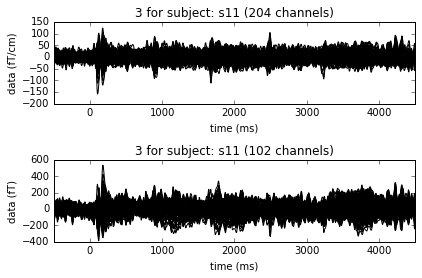

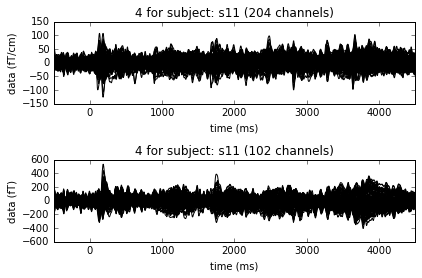

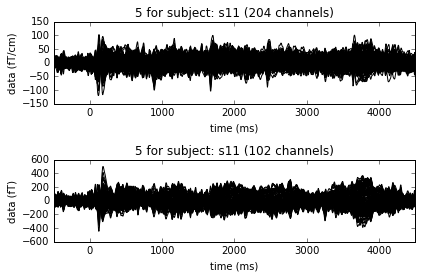

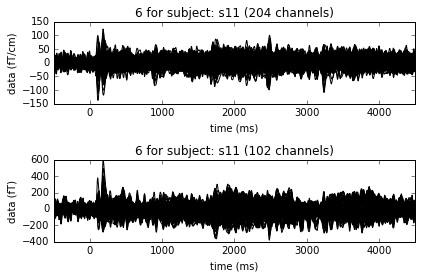

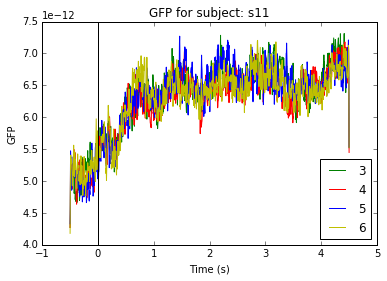

In [5]:
for sub in subjects:
    fname = op.join(data_path, sub + '_calc.mat') 
    epoch = fldtrp2mne(fname, 'data')

    #Baseline-correct & filter data
    print('Baseline-correcting data for subject: ' + sub)
    epoch.apply_baseline(baseline)
    
    #Load condition/behavior info
    matfile = sio.loadmat(fname)
    print('Loading trialinfo for subject: ' + sub)   
    trialinfo = matfile['data']['trialinfo']   
    
    run = trialinfo[0][0][0][0][0].T
    operand1 = trialinfo[0][0][0][0][1].T
    operator = trialinfo[0][0][0][0][2].T
    operand2 = trialinfo[0][0][0][0][3].T
    preResult = trialinfo[0][0][0][0][4].T
    delay = trialinfo[0][0][0][0][5].T
    corrResult = trialinfo[0][0][0][0][6].T
    deviant = trialinfo[0][0][0][0][7].T
    absdeviant = trialinfo[0][0][0][0][8].T
    rt = trialinfo[0][0][0][0][9].T
    respSide = trialinfo[0][0][0][0][10].T

    
    # Merge back and define conditions
    info = pd.DataFrame(data = np.concatenate((run, operand1, operator, operand2, preResult, delay, corrResult, deviant, absdeviant, rt, respSide), axis = 1), 
                        columns = ['run', 'operand1', 'operator', 'operand2', 'preResult', 'delay', 'corrResult', 'deviant', 'absdeviant', 'rt', 'respSide'])

    #info['absdeviant'][info['absdeviant'] != 0] = 1
    op13456 = (info['operand1'] >= 3) & (info['operand1'] <= 6)  
    res3456 = (info['corrResult'] >= 3) & (info['corrResult'] <= 6) & (info['operator'] != 0) 
    
    #info['absdeviant'][info['absdeviant'] != 0] = 1
    results3456 = (info['preResult'] >= 3) & (info['preResult'] <= 6) & (info['operator'] != 0)    
    
    res3 = info['preResult'] == 3
    res4 = info['preResult'] == 4
    res5 = info['preResult'] == 5
    res6 = info['preResult'] == 6
    
    condA = res3
    condB = res4
    condC = res5
    condD = res6

    #Sanity check #1: Plot evoked response
    evoked_condA = epoch[condA].average() # 
    evoked_condB = epoch[condB].average() #   
    evoked_condC = epoch[condC].average() #   
    evoked_condD = epoch[condD].average() #   

    evoked_condA.plot(titles = decCond[0] + ' for subject: ' + sub, show = False)
    evoked_condB.plot(titles = decCond[1] + ' for subject: ' + sub, show = False)
    evoked_condC.plot(titles = decCond[2] + ' for subject: ' + sub, show = False)
    evoked_condD.plot(titles = decCond[3] + ' for subject: ' + sub, show = False)  
    
    plt.show()
    
    #Sanity check #2: Plot GFP
    gfp_condA = np.median(np.std(epoch[condA]._data, axis = 1), axis = 0) #do I need to make sure that the number of trials is similar in the two conditions?
    gfp_condB = np.median(np.std(epoch[condB]._data, axis = 1), axis = 0)
    gfp_condC = np.median(np.std(epoch[condC]._data, axis = 1), axis = 0)
    gfp_condD = np.median(np.std(epoch[condD]._data, axis = 1), axis = 0)

    plt.plot(epoch.times, gfp_condA, color = 'g', label = decCond[0])
    plt.plot(epoch.times, gfp_condB, color = 'r', label = decCond[1])
    plt.plot(epoch.times, gfp_condC, color = 'b', label = decCond[2])
    plt.plot(epoch.times, gfp_condD, color = 'y', label = decCond[3])
    plt.axvline(0, color = 'k') #mark stimulus onset
    plt.legend(loc = 'lower right')
    plt.xlabel('Time (s)')
    plt.ylabel('GFP')
    plt.title('GFP for subject: ' + sub)
    plt.show()
    
   

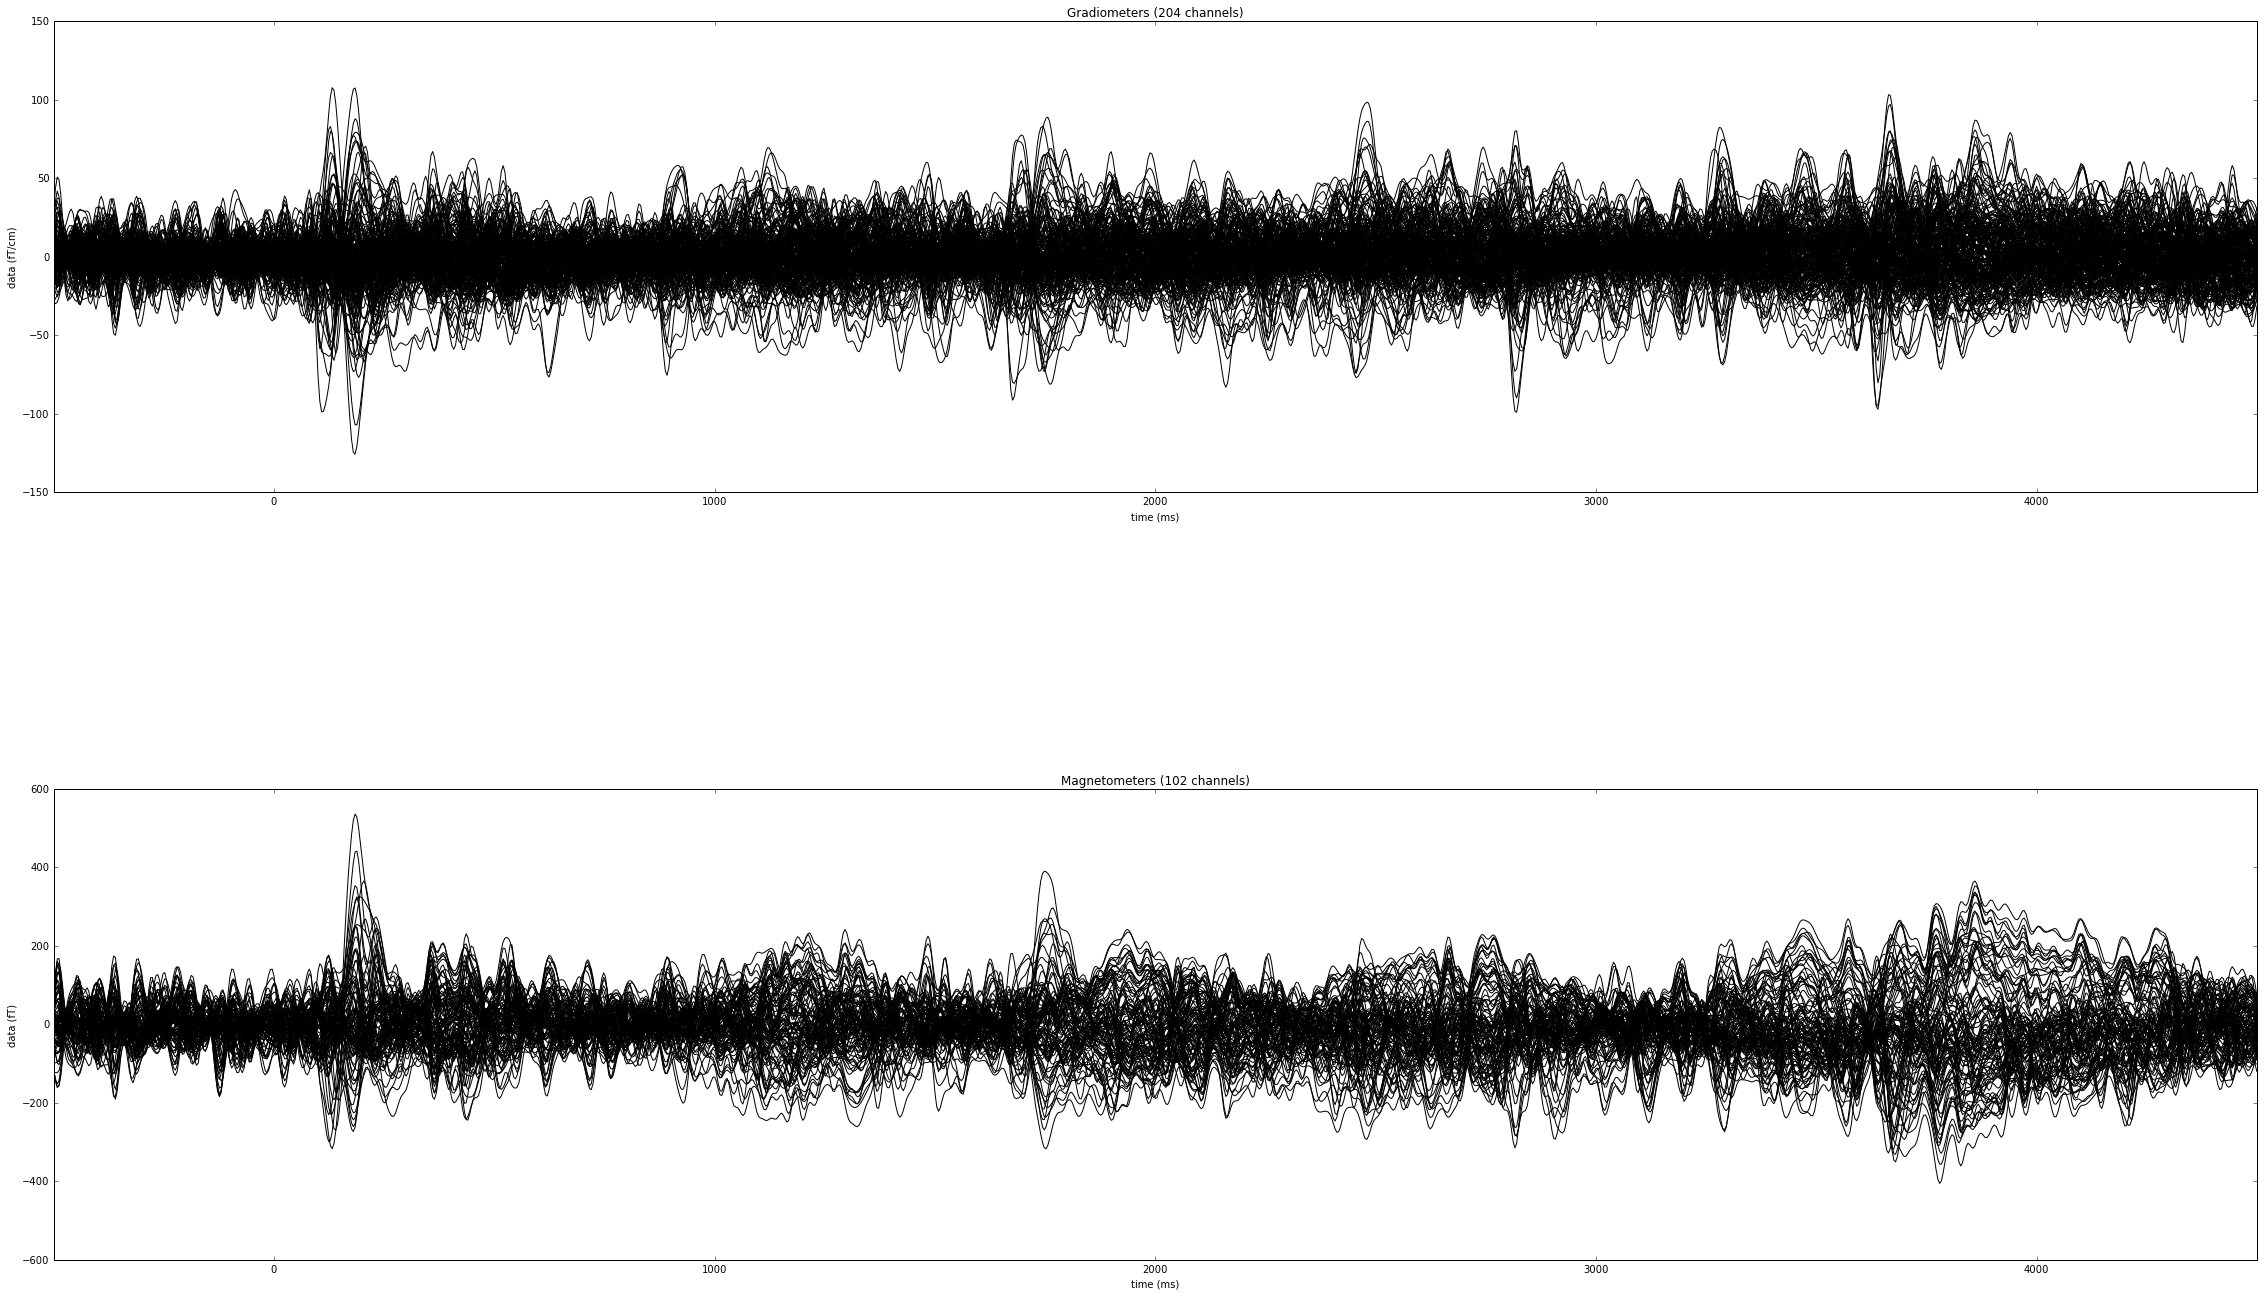

In [12]:
evoked_condB.plot(spatial_colors=False)

rcParams['figure.figsize'] = 40,20

plt.show()

In [ ]:
 # Decoding
    epochs = epoch[results3456] #select only target-present trials
    info = info[results3456]    #
    y = np.array(info['preResult']) #select labels for the conditions
    y = y.astype(numpy.float64)
    # Downsampling for decoding
    epochs.decimate(downsmpDec)
    

    print('Decoding subject: ' + sub)
    gat, score, diagonal = calc_twoClassClassify(epochs, y, [], [], params)
    gat.plot()
    gat.plot_diagonal()  # plot decoding across time (correspond to GAT diagonal)

    #Store scores of different subjects in the same list
    all_scores.append(score)
    all_diagonals.append(diagonal)
    
#Transform into a numpy array   
all_scores = np.array(all_scores)
all_diagonals = np.array(all_diagonals)

# Save individual results
fname = op.join(result_path, 'Classification_presented_result_2try ' + decCond[0] + '_vs_' + 
                decCond[1] + '_vs_' + decCond[2] + '_vs_' + decCond[3] + '_Trainset_' + trainset + '_Testset_' + testset) 
np.save(fname, all_scores)

# Compute group averages
group_scores = np.mean(all_scores, 0)
sem_group_scores = stats.sem(all_scores, 0)

group_diagonal = np.mean(all_diagonals, 0)
sem_group_diagonal = stats.sem(all_diagonals, 0)
    

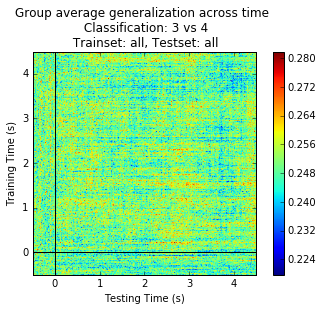

In [32]:
# Plotting  

# Plot GAT
plt.imshow(group_scores, origin = 'lower', extent = [epochs.times[0], epochs.times[len(epochs.times)-1], 
                                                     epochs.times[0], epochs.times[len(epochs.times)-1]]) #flip the matrix around
plt.axvline(0, color = 'k') #mark stimulus onset
plt.axhline(0, color = 'k') #mark stimulus onset
plt.colorbar()
plt.xlabel('Testing Time (s)')
plt.ylabel('Training Time (s)')
plt.title('Group average generalization across time \n Classification: ' + decCond[0] + ' vs ' 
+ decCond[1] + '\n Trainset: ' + trainset + ', Testset: ' + testset)



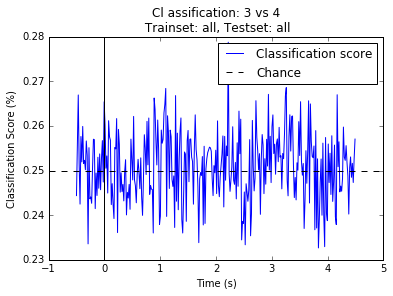

In [33]:
# Plot Diagonal
plt.plot(epochs.times, group_diagonal, label = "Classification score")
plt.axvline(0, color = 'k') #mark stimulus onset
plt.axhline(0.25, color = 'k', ls = '--', label = "Chance") #mark chance level
plt.legend(loc = 'upper right')
plt.xlabel('Time (s)')
plt.ylabel('Classification Score (%)')
plt.title('Cl assification: ' + decCond[0] + ' vs ' 
+ decCond[1] + '\n Trainset: ' + trainset + ', Testset: ' + testset)


In [17]:
size(y)

287

In [16]:
info

,operation,operand1,operand2,absdeviant,corrResult
0,-1,3,0,4,3
1,0,3,33,3,3
2,1,4,1,1,5
5,-1,3,0,4,3
6,0,3,33,3,3
7,0,4,33,3,4
8,-1,5,1,0,4
10,-1,6,3,1,3
11,1,4,0,4,4
13,-1,5,2,3,3
